# NST

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as   optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [5]:
from PIL import Image
import torch
from torchvision import transforms

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

# Transformation pipeline
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # Scale imported image to fixed size
    transforms.ToTensor()  # Transform it into a torch tensor
])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')  # Ensure image is in RGB format
    image = loader(image).unsqueeze(0)  # Fake batch dimension required to fit network's input dimensions
    return image.to(device, torch.float)

# Load style and content images
style_img = image_loader("starry_night.jpg")
content_img = image_loader("renee.jpg")

# Print sizes to debug
print(f"Style image size: {style_img.size()}")
print(f"Content image size: {content_img.size()}")

# Ensure images have the same size
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

print("Style and content images are of the same size.")


Style image size: torch.Size([1, 3, 128, 128])
Content image size: torch.Size([1, 3, 128, 128])
Style and content images are of the same size.


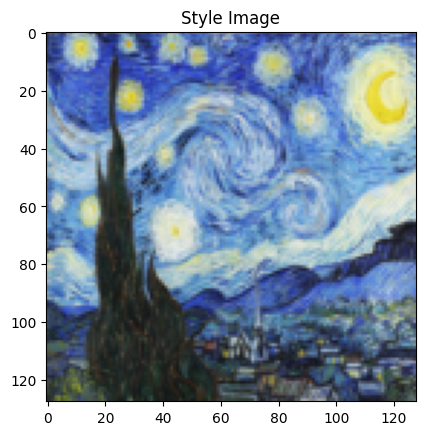

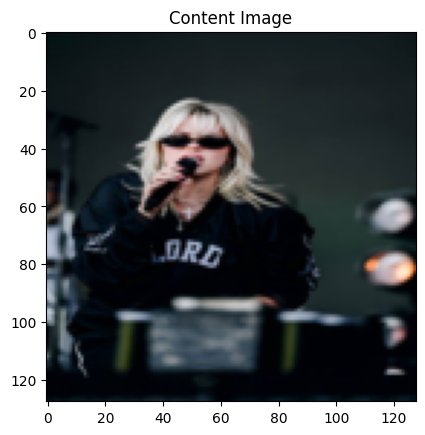

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [12]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

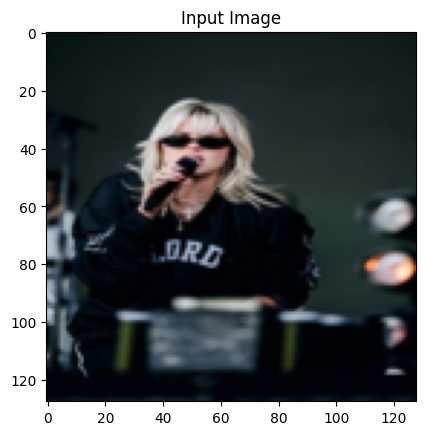

In [13]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [14]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [16]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=2000,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


C:\Users\User\PycharmProjects\TMSds\.venv\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 360.782318 Content Loss: 32.088554
run [100]:
Style Loss : 64.809044 Content Loss: 33.814774
run [150]:
Style Loss : 24.323662 Content Loss: 32.262905

run [200]:
Style Loss : 14.108343 Content Loss: 29.559122

run [250]:
Style Loss : 10.440408 Content Loss: 27.408632

run [300]:
Style Loss : 8.456754 Content Loss: 25.877911

run [350]:
Style Loss : 7.280502 Content Loss: 24.748222
run [400]:
Style Loss : 6.463771 Content Loss: 23.837151
run [450]:
Style Loss : 5.929230 Content Loss: 23.257046

run [500]:
Style Loss : 5.530059 Content Loss: 22.704248
run [550]:
Style Loss : 5.241718 Content Loss: 22.280622

run [600]:
Style Loss : 5.019390 Content Loss: 21.903917

run [650]:
Style Loss : 4.867662 Content Loss: 21.564503

run [700]:
Style Loss : 4.689434 Content Loss: 21.263412

run [750]:
Style Loss : 4.566594 Content Loss: 20.995707

run [800]:
Style Loss : 4.496869 Content Loss: 20.787786

run [850]:
Style Loss : 4.367787 Content Loss: 20.583492

r

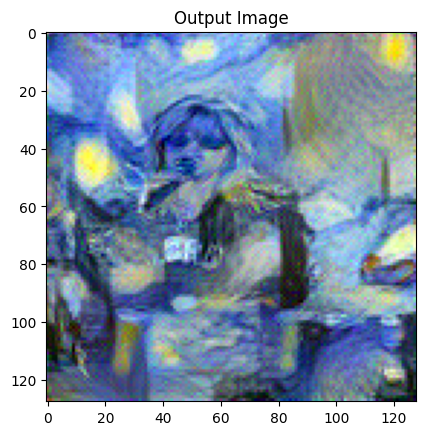

In [17]:
        
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# Image-Style-Transfer-Using-Convolutional-Neural-Networks

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

# Generated image size
RESIZE_HEIGHT = 607

NUM_ITER = 3000

# Weights of the different loss components
CONTENT_WEIGHT = 8e-4 # 8e-4
STYLE_WEIGHT = 8e-1 # 8e-4

# The layer to use for the content loss.
CONTENT_LAYER_NAME = "block5_conv2" # "block2_conv2"

# List of layers to use for the style loss.
STYLE_LAYER_NAMES = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

def get_result_image_size(image_path, result_height):
    image_width, image_height = keras.preprocessing.image.load_img(image_path).size
    result_width = int(image_width * result_height / image_height)
    return result_height, result_width

def preprocess_image(image_path, target_height, target_width):
    img = keras.preprocessing.image.load_img(image_path, target_size = (target_height, target_width))
    arr = keras.preprocessing.image.img_to_array(img)
    arr = np.expand_dims(arr, axis = 0)
    arr = vgg19.preprocess_input(arr)
    return tf.convert_to_tensor(arr)

def get_model():
    # Build a VGG19 model loaded with pre-trained ImageNet weights
    model = vgg19.VGG19(weights = 'imagenet', include_top = False)

    # Get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    # Set up a model that returns the activation values for every layer in VGG19 (as a dict).
    return keras.Model(inputs = model.inputs, outputs = outputs_dict)

def get_optimizer():
    return keras.optimizers.Adam(
        keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 8.0, decay_steps = 445, decay_rate = 0.98
            # initial_learning_rate = 2.0, decay_steps = 376, decay_rate = 0.98
        )
    )

def compute_loss(feature_extractor, combination_image, content_features, style_features):
    combination_features = feature_extractor(combination_image)
    loss_content = compute_content_loss(content_features, combination_features)
    loss_style = compute_style_loss(style_features, combination_features, combination_image.shape[1] * combination_image.shape[2])

    return CONTENT_WEIGHT * loss_content + STYLE_WEIGHT * loss_style

# A loss function designed to maintain the 'content' of the original_image in the generated_image
def compute_content_loss(content_features, combination_features):
    original_image = content_features[CONTENT_LAYER_NAME]
    generated_image = combination_features[CONTENT_LAYER_NAME]

    return tf.reduce_sum(tf.square(generated_image - original_image)) / 2

def compute_style_loss(style_features, combination_features, combination_size):
    loss_style = 0

    for layer_name in STYLE_LAYER_NAMES:
        style_feature = style_features[layer_name][0]
        combination_feature = combination_features[layer_name][0]
        loss_style += style_loss(style_feature, combination_feature, combination_size) / len(STYLE_LAYER_NAMES)

    return loss_style

# The "style loss" is designed to maintain the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of feature maps from the style reference image and from the generated image
def style_loss(style_features, combination_features, combination_size):
    S = gram_matrix(style_features)
    C = gram_matrix(combination_features)
    channels = style_features.shape[2]
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (combination_size ** 2))

def gram_matrix(x):
   x = tf.transpose(x, (2, 0, 1))
   features = tf.reshape(x, (tf.shape(x)[0], -1))
   gram = tf.matmul(features, tf.transpose(features))
   return gram

def save_result(generated_image, result_height, result_width, name):
    img = deprocess_image(generated_image, result_height, result_width)
    keras.preprocessing.image.save_img(name, img)

# Util function to convert a tensor into a valid image
def deprocess_image(tensor, result_height, result_width):
    tensor = tensor.numpy()
    tensor = tensor.reshape((result_height, result_width, 3))

    # Remove zero-center by mean pixel
    tensor[:, :, 0] += 103.939
    tensor[:, :, 1] += 116.779
    tensor[:, :, 2] += 123.680

    # 'BGR'->'RGB'
    tensor = tensor[:, :, ::-1]
    return np.clip(tensor, 0, 255).astype("uint8")

if __name__ == "__main__":
    # Prepare content, style images
    path = os.path.abspath(os.getcwd())
    content_image_path = os.path.join(path, 'letter.jpg')
    style_image_path = os.path.join(path, 'dancing.jpg')
    result_height, result_width = get_result_image_size(content_image_path, RESIZE_HEIGHT)
    print("result resolution: (%d, %d)" % (result_height, result_width))

    # Preprocessing
    content_tensor = preprocess_image(content_image_path, result_height, result_width)
    style_tensor = preprocess_image(style_image_path, result_height, result_width)
    generated_image = tf.Variable(tf.random.uniform(style_tensor.shape, dtype=tf.dtypes.float32))
    # generated_image = tf.Variable(preprocess_image(content_image_path, result_height, result_width))

    # Build model
    model = get_model()
    optimizer = get_optimizer()
    print(model.summary())

    content_features = model(content_tensor)
    style_features = model(style_tensor)

    # Optimize result image
    for iter in range(NUM_ITER):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, generated_image, content_features, style_features)

        grads = tape.gradient(loss, generated_image)

        print("iter: %4d, loss: %8.f" % (iter, loss))
        optimizer.apply_gradients([(grads, generated_image)])

        if (iter + 1) % 100 == 0:
            name = "result/generated_at_iteration_%d.png" % (iter + 1)
            save_result(generated_image, result_height, result_width, name)

    name = "result/result_%d_%f_%f.png" % (NUM_ITER, CONTENT_WEIGHT, STYLE_WEIGHT)
    save_result(generated_image, result_height, result_width, name)